# Explore here

In [1]:
!pip install seaborn
!pip install scikit-learn
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from pickle import dump

In [3]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv"
df = pd.read_csv(url)

In [4]:
# Buscamos 0 en columnas donde no tiene sentido un valor de 0
# Lista de columnas
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']

# Crear una máscara booleana para filas donde alguna de las columnas especificadas tiene un valor 0
mask = (df[columns_to_check] == 0).any(axis=1)

# Usar la máscara para filtrar el DataFrame
rows_with_zeros = df.loc[mask]

print(rows_with_zeros)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
5              5      116             74              0        0  25.6   
7             10      115              0              0        0  35.3   
..           ...      ...            ...            ...      ...   ...   
761            9      170             74             31        0  44.0   
762            9       89             62              0        0  22.5   
764            2      122             70             27        0  36.8   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

In [5]:
# Crear una copia del dataframe con valores faltantes marcados
df_missing = df.copy()
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_missing[columns_with_zeros] = df_missing[columns_with_zeros].replace(0, np.nan)

# Agregar una columna para contar los valores faltantes por fila
df_missing['missing_values'] = df_missing.isnull().sum(axis=1)

# Ver las filas con valores faltantes ordenadas por 'missing_values'
print(df_missing.sort_values(by='missing_values', ascending=False).head(20))

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
60             2     84.0            NaN            NaN      NaN   NaN   
81             2     74.0            NaN            NaN      NaN   NaN   
522            6    114.0            NaN            NaN      NaN   NaN   
494            3     80.0            NaN            NaN      NaN   NaN   
49             7    105.0            NaN            NaN      NaN   NaN   
706           10    115.0            NaN            NaN      NaN   NaN   
426            0     94.0            NaN            NaN      NaN   NaN   
430            2     99.0            NaN            NaN      NaN  22.2   
533            6     91.0            NaN            NaN      NaN  29.8   
269            2    146.0            NaN            NaN      NaN  27.5   
261            3    141.0            NaN            NaN      NaN  30.0   
703            2    129.0            NaN            NaN      NaN  38.5   
697            0     99.0            N

In [6]:
# Escalado de características para mejorar el rendimiento de KNN
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Aplicación de KNNImputer
# Puedes ajustar el número de vecinos si es necesario
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df.columns)

# Deshacer el escalado para volver al rango original de los datos
df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), columns=df.columns)

# Verificar el resultado de la imputación
print(df_imputed.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [7]:
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Escalado Min-Max en el conjunto de entrenamiento (consideramos suficiente para normalizar los datos y tratar los outliers)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar el mismo escalado al conjunto de prueba
X_test_scaled = scaler.transform(X_test)

# Transformación logarítmica para las variables con sesgo significativo en el conjunto de entrenamiento
skewed_features = ['Insulin', 'SkinThickness', 'DiabetesPedigreeFunction']
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled[skewed_features] = X_train_scaled[skewed_features].apply(lambda x: np.log1p(x))

# Aplicar la misma transformación al conjunto de prueba
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled[skewed_features] = X_test_scaled[skewed_features].apply(lambda x: np.log1p(x))

In [9]:
# Vamos a estudiar el árbol de decisión usando los criterios gini y entropy
criteria = ['gini', 'entropy']
for criterion in criteria:
    tree = DecisionTreeClassifier(criterion=criterion, random_state=42)
    tree.fit(X_train_scaled, y_train)
    y_pred = tree.predict(X_test_scaled)
    
    print(f"\nÁrbol de decisión usando {criterion}:")
    print("Reporte de clasificación:")
    print(classification_report(y_test, y_pred))


Árbol de decisión usando gini:
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.83      0.76      0.79        99
         1.0       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


Árbol de decisión usando entropy:
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78        99
         1.0       0.61      0.65      0.63        55

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.73      0.73      0.73       154



In [10]:
# Definimos el espacio de parámetros para GridSearchCV
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5)
}

# Inicializamos el GridSearchCV con el modelo de árbol de decisión y los parámetros definidos
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")
best_tree = grid_search.best_estimator_

Mejores parámetros: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [11]:
# Evaluamos el mejor modelo encontrado con el conjunto de prueba
y_pred_best = best_tree.predict(X_test_scaled)
print("Reporte de clasificación para el mejor árbol:")
print(classification_report(y_test, y_pred_best))

Reporte de clasificación para el mejor árbol:
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76        99
         1.0       0.57      0.64      0.60        55

    accuracy                           0.70       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.71      0.70      0.70       154



In [12]:
# Realizamos validación cruzada en el conjunto completo de datos
# Usamos el mejor árbol encontrado por GridSearchCV
cross_val_scores = cross_val_score(best_tree, X, y, cv=5, scoring='accuracy')

# Mostramos los resultados
cross_val_scores_mean = cross_val_scores.mean()
cross_val_scores_std = cross_val_scores.std()

cross_val_scores_mean, cross_val_scores_std

(0.7279178338001867, 0.02902179333216417)

In [13]:
dump(best_tree, open("decision_tree_classifier_best_42.sav", "wb"))

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

In [15]:
# Inicializar el modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=101, max_depth= 10, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
random_forest_model.fit(X_train_scaled, y_train)

# Predecir con el conjunto de prueba
y_pred_rf = random_forest_model.predict(X_test_scaled)

# Evaluar el modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy del Random Forest: {accuracy_rf}")

Accuracy del Random Forest: 0.7467532467532467


In [16]:
# Definir el espacio de parámetros para explorar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Inicializar el GridSearchCV con el modelo y el espacio de parámetros
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenar el GridSearchCV con el conjunto de entrenamiento
rf_grid_search.fit(X_train_scaled, y_train)

# Mejores hiperparámetros encontrados
best_params = rf_grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

# Mejor modelo encontrado
best_rf_model = rf_grid_search.best_estimator_

# Evaluar el mejor modelo encontrado
y_pred_best_rf = best_rf_model.predict(X_test_scaled)
best_accuracy_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Accuracy del mejor Random Forest: {best_accuracy_rf}")

Mejores parámetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Accuracy del mejor Random Forest: 0.7532467532467533


In [17]:
# Ya que tenemos el mejor modelo encontrado por GridSearchCV y las predicciones, evaluamos más métricas
report = classification_report(y_test, y_pred_best_rf)
roc_auc = roc_auc_score(y_test, y_pred_best_rf)

report, roc_auc

('              precision    recall  f1-score   support\n\n         0.0       0.82      0.79      0.80        99\n         1.0       0.64      0.69      0.67        55\n\n    accuracy                           0.75       154\n   macro avg       0.73      0.74      0.74       154\nweighted avg       0.76      0.75      0.76       154\n',
 0.7393939393939394)

In [18]:
# Vamos a intentar mejorar más los parámetros con un RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2']
}

# Inicializar RandomizedSearchCV con el modelo y el espacio de parámetros
# n_iter establece el número de diferentes combinaciones para probar
# cv es el número de cross-validation folds
rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                                      param_distributions=param_dist, 
                                      n_iter=100, 
                                      cv=5, 
                                      scoring='accuracy', 
                                      n_jobs=-1, 
                                      random_state=42)

# Entrenar RandomizedSearchCV con el conjunto de entrenamiento
rf_random_search.fit(X_train_scaled, y_train)

# Mejores hiperparámetros encontrados
best_random_params = rf_random_search.best_params_
print(f"Mejores hiperparámetros: {best_random_params}")

# Mejor modelo encontrado
best_random_rf_model = rf_random_search.best_estimator_

# Realizar validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_random_rf_model, X, y, cv=5, scoring='accuracy')

# Resultados de la validación cruzada
cv_scores_mean = cv_scores.mean()
cv_scores_std = cv_scores.std()

cv_scores_mean, cv_scores_std

Mejores hiperparámetros: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 40}


(0.7670316611493082, 0.03836304387452925)

Accuracy en el conjunto de prueba: 0.7597402597402597

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81        99
         1.0       0.67      0.65      0.66        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

Puntuación AUC-ROC: 0.7363636363636363


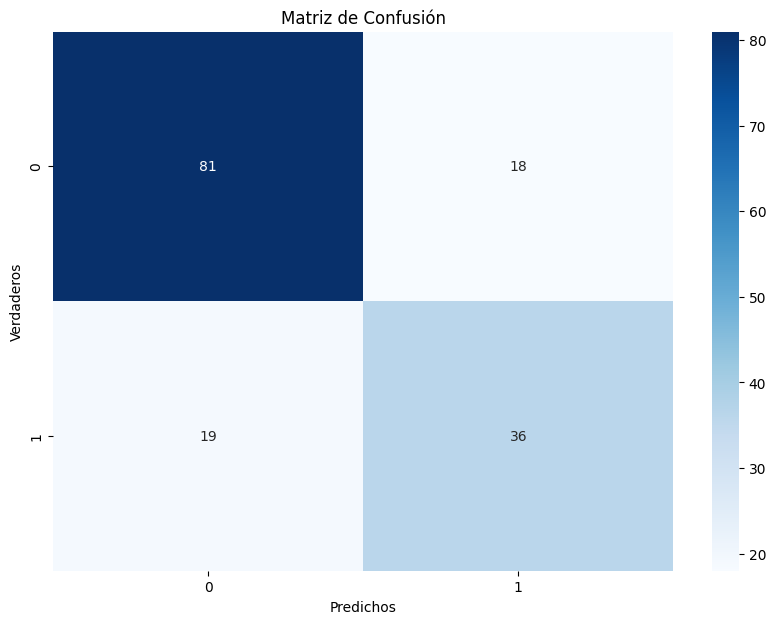

In [19]:
# Realizar predicciones con el mejor modelo en el conjunto de prueba
y_pred_test = best_random_rf_model.predict(X_test_scaled)

# Calcular la exactitud
accuracy = accuracy_score(y_test, y_pred_test)

# Generar un reporte de clasificación
class_report = classification_report(y_test, y_pred_test)

# Calcular la puntuación AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_test)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Imprimir las métricas
print(f"Accuracy en el conjunto de prueba: {accuracy}")
print("\nReporte de clasificación:")
print(class_report)
print(f"Puntuación AUC-ROC: {roc_auc}")

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predichos')
plt.ylabel('Verdaderos')
plt.show()

In [20]:
# Hemos encontrado que el modelo con ajuste de hiperparámetros por RandomSearchCV es ligeramente mejor que el de GridSearch
# No obstante, vamos a guardar sendos modelos, sabiendo que el segundo es algo superior
dump(best_rf_model, open("random_forest_classifier_best_grid_42.sav", "wb"))
dump(best_random_rf_model, open("random_forest_classifier_best_randsrch_42.sav", "wb"))

## Comenzamos el proyecto desde el final del proyecto anterior (se han omitido algunas representaciones y métricas)

In [21]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [22]:
import xgboost as xgb

Accuracy del modelo XGBoost: 0.7532467532467533
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81        99
         1.0       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



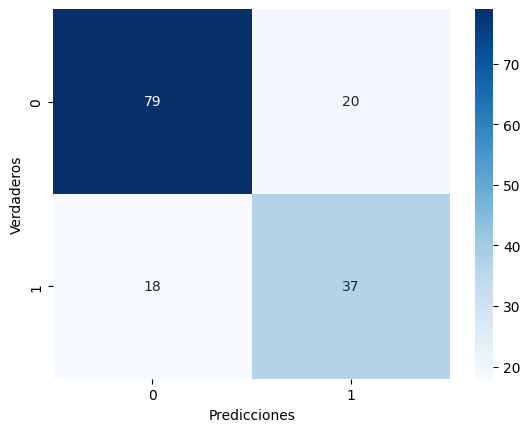

In [23]:
# Inicializar el clasificador XGBoost con parámetros iniciales
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42)

# Definir un espacio de búsqueda de hiperparámetros para la optimización
param_dist = {
    'n_estimators': [50, 100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Inicializar RandomizedSearchCV con el clasificador y el espacio de parámetros
xgb_random = RandomizedSearchCV(xgb_clf, 
                                param_distributions=param_dist, 
                                n_iter=100, 
                                scoring='accuracy', 
                                n_jobs=-1, 
                                cv=5, 
                                random_state=42)

# Ajustar RandomizedSearchCV en el conjunto de entrenamiento
xgb_random.fit(X_train, y_train)

# Obtener el mejor estimador
best_xgb_clf = xgb_random.best_estimator_

# Realizar predicciones con el mejor modelo sobre el conjunto de prueba
y_pred = best_xgb_clf.predict(X_test)

# Evaluar la exactitud
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo XGBoost: {accuracy}")

# Generar y mostrar el reporte de clasificación
report = classification_report(y_test, y_pred)
print(report)

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

Accuracy del modelo XGBoost: 0.7532467532467533
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81        99
         1.0       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



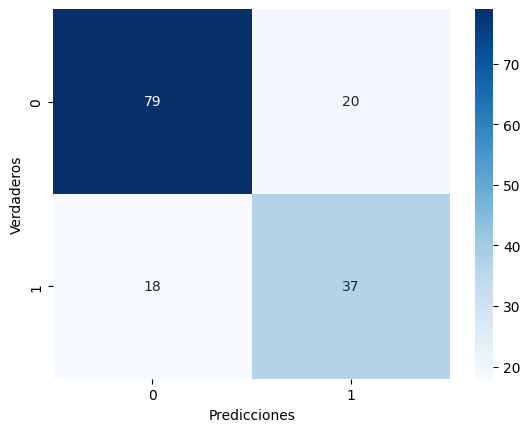

In [27]:
# Mismo proceso pero trabajando con los datos escalados (para comprobar la influencia o no del escalado de datos)
# Inicializar el clasificador XGBoost con parámetros iniciales
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42)

# Definir un espacio de búsqueda de hiperparámetros para la optimización
param_dist = {
    'n_estimators': [50, 100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Inicializar RandomizedSearchCV con el clasificador y el espacio de parámetros
xgb_random = RandomizedSearchCV(xgb_clf, 
                                param_distributions=param_dist, 
                                n_iter=100, 
                                scoring='accuracy', 
                                n_jobs=-1, 
                                cv=5, 
                                random_state=42)

# Ajustar RandomizedSearchCV en el conjunto de entrenamiento
xgb_random.fit(X_train_scaled, y_train)

# Obtener el mejor estimador
best_xgb_clf = xgb_random.best_estimator_

# Realizar predicciones con el mejor modelo sobre el conjunto de prueba
y_pred1 = best_xgb_clf.predict(X_test_scaled)

# Evaluar la exactitud
accuracy = accuracy_score(y_test, y_pred1)
print(f"Accuracy del modelo XGBoost: {accuracy}")

# Generar y mostrar el reporte de clasificación
report = classification_report(y_test, y_pred1)
print(report)

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

Hemos obtenido idénticos resultados, con escalado y sin escalado.

## ANÁLISIS
Los resultados con XGBoost muestran una exactitud similar al modelo optimizado con RandomizedSearchCV para el Random Forest:

Exactitud (Accuracy) de XGBoost: 75.32%
Exactitud (Accuracy) del Random Forest optimizado con RandomizedSearchCV: 75.97%

Ambos modelos tienen rendimientos bastante cercanos, aunque el Random Forest tiene una ligera ventaja en términos de exactitud. Sin embargo, la diferencia es mínima y podría no ser significativa dependiendo de la variabilidad del conjunto de datos y la importancia de las otras métricas como precisión y sensibilidad.

Las otras métricas (precisión, recall, f1-score) son también muy similares entre los dos modelos, con ligeras variaciones. Por ejemplo, en el modelo de XGBoost, el recall para la clase 1 (diabetes) es ligeramente superior al del Random Forest, lo que indica que podría ser un poco más eficaz en la identificación de casos positivos.

## Vamos a intentar mejorar los resultados aplicando GridSearchCV

In [30]:
# Configuración de hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Inicializar el clasificador XGBoost
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Ajustar GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train_scaled, y_train)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Mejor modelo
best_model_xgb_grid = grid_search.best_estimator_

# Realizar predicciones y evaluar el modelo
y_pred2 = best_model_xgb_grid.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Mejores hiperparámetros: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
Accuracy: 0.7532467532467533


              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81        99
         1.0       0.65      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154



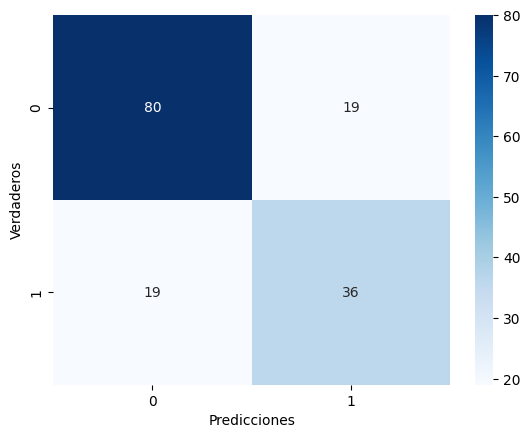

In [31]:
# Generar y mostrar el reporte de clasificación
report = classification_report(y_test, y_pred2)
print(report)

# Mostrar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()

## ANÁLISIS
### Robustez del XGBoost: 
El hecho de que el modelo XGBoost ofrezca resultados consistentes tanto en datos sin escalar como en datos escalados sugiere que es robusto a estas transformaciones. Esto es típico en modelos basados en árboles, como el XGBoost, ya que el escalado de las características no afecta la construcción del modelo de árboles de decisión.

### Estabilidad del modelo: 
El que los resultados sean consistentes después de realizar la búsqueda aleatoria y la búsqueda en cuadrícula (GridSearch) indica que hemos encontrado un modelo estable para el conjunto de datos. Los hiperparámetros óptimos están proporcionando resultados comparables, lo que significa que pequeñas variaciones en estos no están teniendo un impacto significativo en el rendimiento del modelo.

## CONCLUSIÓN
Los modelos XGBoost entrenados son estables y robustos en este conjunto de datos.

La elección de si escalar o no los datos antes del entrenamiento del modelo no parece afectar al rendimiento de forma significativa.

In [32]:
dump(best_model_xgb_grid, open("xgboost_best_grid_42.sav", "wb"))

Hemos decidido guardar el último modelo, con GridSearch y con los datos escalados. De esta manera, podremos probar el futuro con otros algoritmos que requieran escalado. Y ya sabemos que el escalado no ha afectado en nada al rendimiento del XGBoost.